In [1]:
ESD_ROOT     = "/content/drive/MyDrive/adsp/downloads/esd"
IEMOCAP_ROOT = "/content/drive/MyDrive/adsp/downloads/iemocap"


In [2]:
# --- Colab: mount Google Drive ---
from google.colab import drive
drive.mount("/content/drive")

# --- Install libraries (run once) ---
!pip install -q "transformers>=4.43" accelerate datasets sentencepiece \
               librosa soundfile scikit-learn seaborn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, glob, warnings
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import torch
from tqdm.auto import tqdm

from transformers import (
    AutoProcessor,
    Qwen2AudioForConditionalGeneration,
    pipeline as hf_pipeline,
)

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Silence some noisy warnings
warnings.filterwarnings("ignore")

ESD_ROOT     = "/content/drive/MyDrive/adsp/downloads/esd"
IEMOCAP_ROOT = "/content/drive/MyDrive/adsp/downloads/iemocap"

# Our 5-class mapping
EMO_LABELS = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]

# IEMOCAP: map original labels -> our 5 labels (others -> None = drop)
IEMO_EMO_MAP = {
    "ang": "Angry",
    "angry": "Angry",
    "fru": "Angry",       # frustration -> Angry-ish
    "frustrated": "Angry",

    "hap": "Happy",
    "happy": "Happy",
    "exc": "Happy",       # excited -> Happy
    "excited": "Happy",

    "neu": "Neutral",
    "neutral": "Neutral",

    "sad": "Sad",

    "sur": "Surprise",
    "surprise": "Surprise",
}


In [5]:
def load_audio(path, target_sr=16000):
    """
    Load a mono audio signal at target_sr.
    Uses soundfile first, then falls back to librosa.
    """
    try:
        y, sr = sf.read(path)
        # stereo -> mono
        if y.ndim > 1:
            y = np.mean(y, axis=1)
    except Exception:
        # fall back to librosa
        y, sr = librosa.load(path, sr=None, mono=True)

    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y, sr


In [6]:
def load_esd(root):
    rows = []

    speakers = sorted(d for d in os.listdir(root) if d.isdigit())
    print("Speakers found:", speakers)

    for spk in speakers:
        spk_dir = os.path.join(root, spk)
        txt_path = os.path.join(spk_dir, f"{spk}.txt")
        if not os.path.exists(txt_path):
            print(f"[ESD] Missing transcript file for speaker {spk}: {txt_path}")
            continue

        # --- build utt_id -> transcript mapping for this speaker ---
        utt2text = {}
        with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                # split on first whitespace or tab
                parts = line.split(None, 1)
                if len(parts) == 1:
                    wav_name, text = parts[0], ""
                else:
                    wav_name, text = parts
                wav_name = wav_name.replace(".wav", "")
                utt2text[wav_name] = text

        # --- go through each emotion folder ---
        for emo in EMO_LABELS:
            emo_dir = os.path.join(spk_dir, emo)
            if not os.path.isdir(emo_dir):
                continue

            for wav_file in glob.glob(os.path.join(emo_dir, "*.wav")):
                base = os.path.basename(wav_file)
                stem = os.path.splitext(base)[0]  # e.g. 0015_001077

                text = utt2text.get(stem, "")
                rows.append({
                    "path": wav_file,
                    "text": text,
                    "label": emo,
                })

    df = pd.DataFrame(rows)
    print("ESD rows:", len(df))
    if not df.empty:
        print("\nESD label counts:")
        print(df["label"].value_counts())
    return df

df_esd = load_esd(ESD_ROOT)
df_esd.head()


Speakers found: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020']
ESD rows: 35013

ESD label counts:
label
Sad         7013
Angry       7000
Happy       7000
Neutral     7000
Surprise    7000
Name: count, dtype: int64


,path,text,label
0,/content/drive/MyDrive/adsp/downloads/esd/0001...,他一定是一眼就被你迷住了。\t生气,Angry
1,/content/drive/MyDrive/adsp/downloads/esd/0001...,谁你也不认识，我很乐意帮助你。\t生气,Angry
2,/content/drive/MyDrive/adsp/downloads/esd/0001...,我特别喜欢网球和登山。\t生气,Angry
3,/content/drive/MyDrive/adsp/downloads/esd/0001...,英国的哲学家曾经说过“\t生气,Angry
4,/content/drive/MyDrive/adsp/downloads/esd/0001...,我每个月打一次电话。\t生气,Angry


In [7]:
def parse_iemocap_emo(root):
    """
    Parse SessionX/dialog/EmoEvaluation/*.txt
    Returns dict: utt_id -> mapped_label (or None).
    """
    utt2emo = {}
    sessions = sorted(d for d in os.listdir(root) if d.startswith("Session"))
    print("Sessions found:", sessions)

    for sess in sessions:
        emo_dir = os.path.join(root, sess, "dialog", "EmoEvaluation")
        if not os.path.isdir(emo_dir):
            continue

        for emo_file in os.listdir(emo_dir):
            if not emo_file.endswith(".txt"):
                continue
            with open(os.path.join(emo_dir, emo_file),
                      "r",
                      encoding="utf-8",
                      errors="ignore") as f:
                for line in f:
                    line = line.strip()
                    if not line.startswith("["):
                        continue
                    # Typical format:
                    # [start - end] \t utt_id \t emo \t ...
                    parts = line.split("\t")
                    if len(parts) < 3:
                        continue
                    utt_id = parts[1].strip()
                    emo_raw = parts[2].strip().lower()
                    emo = IEMO_EMO_MAP.get(emo_raw)
                    if emo is not None:
                        utt2emo[utt_id] = emo
    return utt2emo


def load_iemocap(root):
    utt2emo = parse_iemocap_emo(root)
    print("Raw IEMOCAP rows with mapped emotions:", len(utt2emo))

    rows = []
    sessions = sorted(d for d in os.listdir(root) if d.startswith("Session"))

    for sess in sessions:
        sent_wav_root = os.path.join(root, sess, "sentences", "wav")
        sent_txt_root = os.path.join(root, sess, "sentences", "ForcedAlignment")
        if not os.path.isdir(sent_wav_root):
            continue

        # Each subdir corresponds to a dialog id (Ses01F_impro01, etc.)
        for dialog in os.listdir(sent_wav_root):
            wav_dir = os.path.join(sent_wav_root, dialog)
            txt_dir = os.path.join(sent_txt_root, dialog)

            if not os.path.isdir(wav_dir):
                continue

            for wav_file in os.listdir(wav_dir):
                if not wav_file.endswith(".wav"):
                    continue

                utt_id = os.path.splitext(wav_file)[0]  # e.g. Ses01F_impro01_M000
                emo = utt2emo.get(utt_id)
                if emo is None:
                    continue  # not in our 5 classes

                wav_path = os.path.join(wav_dir, wav_file)

                # Forced-alignment transcript
                txt_path = os.path.join(txt_dir, utt_id + ".txt")
                text = ""
                if os.path.exists(txt_path):
                    words = []
                    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) == 3:
                                w = parts[2]
                                if w not in {"sil", "sp"}:
                                    words.append(w)
                    text = " ".join(words)

                rows.append({
                    "path": wav_path,
                    "text": text,
                    "label": emo,
                })

    df = pd.DataFrame(rows)
    print("IEMOCAP rows:", len(df))

    if not df.empty:
        print("\nIEMOCAP label counts:")
        print(df["label"].value_counts())
    return df


df_iemo = load_iemocap(IEMOCAP_ROOT)
df_iemo.head()


Sessions found: ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
Raw IEMOCAP rows with mapped emotions: 7487
IEMOCAP rows: 7450

IEMOCAP label counts:
label
Angry       2933
Neutral     1693
Happy       1636
Sad         1081
Surprise     107
Name: count, dtype: int64


,path,text,label
0,/content/drive/MyDrive/adsp/downloads/iemocap/...,,Sad
1,/content/drive/MyDrive/adsp/downloads/iemocap/...,,Sad
2,/content/drive/MyDrive/adsp/downloads/iemocap/...,,Sad
3,/content/drive/MyDrive/adsp/downloads/iemocap/...,,Sad
4,/content/drive/MyDrive/adsp/downloads/iemocap/...,,Neutral


In [8]:
QWEN_AUDIO_ID = "Qwen/Qwen2-Audio-7B-Instruct"

processor = AutoProcessor.from_pretrained(QWEN_AUDIO_ID)

model = Qwen2AudioForConditionalGeneration.from_pretrained(
    QWEN_AUDIO_ID,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.eval()

print("Qwen2-Audio loaded.")


`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.91G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

Qwen2-Audio loaded.


In [9]:
device_idx = 0 if torch.cuda.is_available() else -1

whisper_asr = hf_pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",   # change to tiny/base if memory is tight
    device=device_idx,
)

def whisper_transcribe(path):
    """
    Run Whisper ASR on one wav file and return transcript text.
    """
    out = whisper_asr(path, return_timestamps=False)
    return out["text"].strip()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [10]:
def add_whisper_text(df, max_samples=None):
    df = df.copy()
    if max_samples is not None and max_samples < len(df):
        df = df.sample(max_samples, random_state=42).reset_index(drop=True)

    w_texts = []
    for p in tqdm(df["path"], desc="Whisper ASR"):
        try:
            w_texts.append(whisper_transcribe(p))
        except Exception as e:
            print("ASR error on", p, "->", type(e).__name__, e)
            w_texts.append("")
    df["whisper_text"] = w_texts
    return df

# Example: limit to 500 for speed while debugging
df_esd_w  = add_whisper_text(df_esd,  max_samples=500)
df_iemo_w = add_whisper_text(df_iemo, max_samples=500)


Whisper ASR:   0%|          | 0/500 [00:00<?, ?it/s]

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


ASR error on /content/drive/MyDrive/adsp/downloads/esd/0015/Sad/0015_001077.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.
ASR error on /content/drive/MyDrive/adsp/downloads/esd/0019/Sad/0019_001258.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.
ASR error on /content/drive/MyDrive/adsp/downloads/esd/0015/Sad/0015_001239.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


ASR error on /content/drive/MyDrive/adsp/downloads/esd/0009/Surprise/0009_001615.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.
ASR error on /content/drive/MyDrive/adsp/downloads/esd/0020/Happy/0020_000744.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.
ASR error on /content/drive/MyDrive/adsp/downloads/esd/0020/Sad/0020_001067.wav -> ValueError Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If 

Whisper ASR:   0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
SYSTEM_PROMPT = (
    "You are an emotion classifier. "
    "You must answer with EXACTLY one word from this list: "
    "Angry, Happy, Neutral, Sad, Surprise. "
    "Do not add any explanation."
)

def build_user_prompt(with_text, text=None):
    if with_text and text:
        return (
            "Listen to the audio and read the transcript. "
            "Then decide the speaker's emotion and answer with one word.\n\n"
            f"Transcript: \"{text}\""
        )
    else:
        return (
            "Listen to the audio and decide the speaker's emotion. "
            "Answer with exactly one word from: Angry, Happy, Neutral, Sad, Surprise."
        )


def classify_one(audio_path, transcript=None, with_text=True):
    """
    Run Qwen2-Audio once and return predicted label & raw text.
    """
    # load audio
    audio, sr = load_audio(audio_path, target_sr=16000)

    # build ChatML-style messages
    user_content = [{"type": "audio", "audio": audio}]
    user_prompt  = build_user_prompt(with_text, transcript)
    user_content.append({"type": "text", "text": user_prompt})

    messages = [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_PROMPT}]},
        {"role": "user",   "content": user_content},
    ]

    text_input = processor.apply_chat_template(
        messages,
        add_generation_prompt=True
    )

    inputs = processor(
        text=text_input,
        audios=audio,
        sampling_rate=sr,
        return_tensors="pt",
    )

    # move tensors to model's first device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=4,
            do_sample=False,
            temperature=0.0,
        )

    output_text = processor.batch_decode(gen_ids[:, inputs["input_ids"].shape[-1]:],
                                         skip_special_tokens=True)[0]
    # Very rough normalisation
    pred = output_text.strip().split()[0].strip(".,!?").capitalize()
    if pred not in EMO_LABELS:
        # fallback: try to map substrings
        lower = output_text.lower()
        for lab in EMO_LABELS:
            if lab.lower() in lower:
                pred = lab
                break
        else:
            pred = "Neutral"  # dummy default
    return pred, output_text


In [12]:
def classify_batch(df, mode="audio", max_samples=None):
    """
    df must contain at least: path, label, text, whisper_text

    mode:
      - "audio"
      - "audio+gold"
      - "audio+whisper"
    """
    assert mode in {"audio", "audio+gold", "audio+whisper"}

    if max_samples is not None and max_samples < len(df):
        df = df.sample(max_samples, random_state=42).reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)

    preds = []
    gens  = []

    use_text_col = None
    if mode == "audio+gold":
        use_text_col = "text"
    elif mode == "audio+whisper":
        use_text_col = "whisper_text"

    with_text_flag = use_text_col is not None

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Classify ({mode})"):
        audio_path = row["path"]
        transcript = row[use_text_col] if use_text_col else None

        try:
            lab, raw = classify_one(audio_path, transcript, with_text=with_text_flag)
        except Exception as e:
            print("Error on", audio_path, "->", type(e).__name__, e)
            continue

        preds.append(lab)
        gens.append(raw)

    out_df = df.iloc[:len(preds)].copy()
    out_df["pred_label"]   = preds
    out_df["raw_generation"] = gens

    return out_df


In [13]:
def evaluate_predictions(df, title=""):
    y_true = df["label"].tolist()
    y_pred = df["pred_label"].tolist()

    acc = accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred, labels=EMO_LABELS)

    print(f"{title}  Accuracy: {acc:.3f}")
    print("Samples:", len(df))

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMO_LABELS,
        yticklabels=EMO_LABELS,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

    return acc, cm


>>> ESD – AUDIO ONLY


Classify (audio):   0%|          | 0/200 [00:00<?, ?it/s]

Keyword argument `audios` is not a valid argument for this processor and will be ignored.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Happy/0013_000892.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0016/Sad/0016_001080.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001539.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001502.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0020/Angry/0020_000639.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Sad/0013_001141.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0019/Neutral/0019_000138.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Surprise/0009_001615.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0007/Surprise/0007_001547.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Neutral/0009_000103.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0014/Sad/0014_001239.wav ->

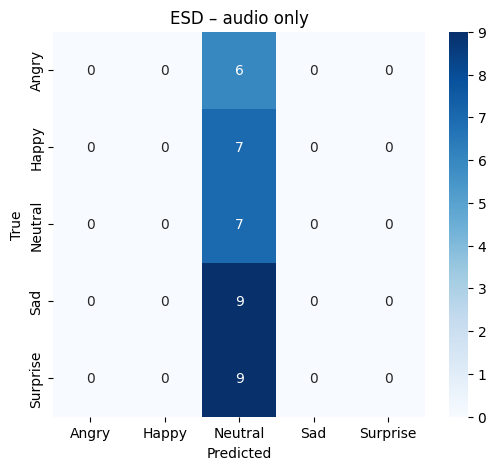

>>> ESD – AUDIO + GOLD TRANSCRIPT


Classify (audio+gold):   0%|          | 0/200 [00:00<?, ?it/s]

Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Happy/0013_000892.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0016/Sad/0016_001080.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001539.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001502.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0020/Angry/0020_000639.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Sad/0013_001141.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0019/Neutral/0019_000138.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Surprise/0009_001615.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0007/Surprise/0007_001547.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Neutral/0009_000103.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0014/Sad/0014_001239.wav ->

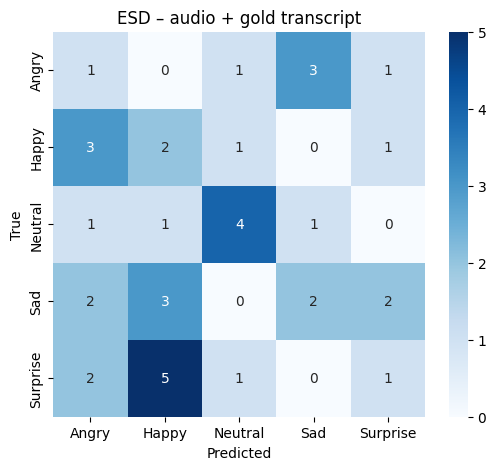

>>> ESD – AUDIO + WHISPER TRANSCRIPT


Classify (audio+whisper):   0%|          | 0/200 [00:00<?, ?it/s]

Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Happy/0013_000892.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0016/Sad/0016_001080.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001539.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0018/Surprise/0018_001502.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0020/Angry/0020_000639.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0013/Sad/0013_001141.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0019/Neutral/0019_000138.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Surprise/0009_001615.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0007/Surprise/0007_001547.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0009/Neutral/0009_000103.wav -> EOFError 
Error on /content/drive/MyDrive/adsp/downloads/esd/0014/Sad/0014_001239.wav ->

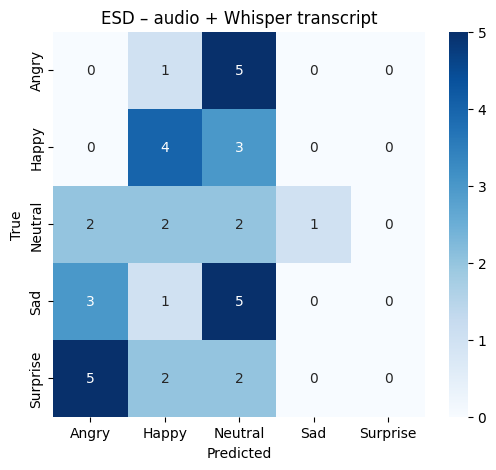

>>> IEMOCAP – AUDIO ONLY


Classify (audio):   0%|          | 0/200 [00:00<?, ?it/s]

IEMOCAP – audio only  Accuracy: 0.220
Samples: 200


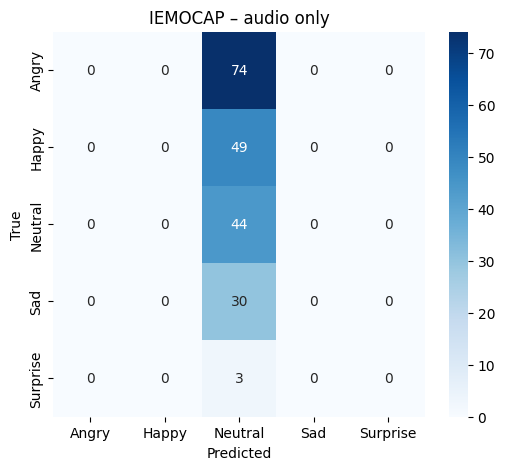

>>> IEMOCAP – AUDIO + GOLD TRANSCRIPT


Classify (audio+gold):   0%|          | 0/200 [00:00<?, ?it/s]

IEMOCAP – audio + gold transcript  Accuracy: 0.220
Samples: 200


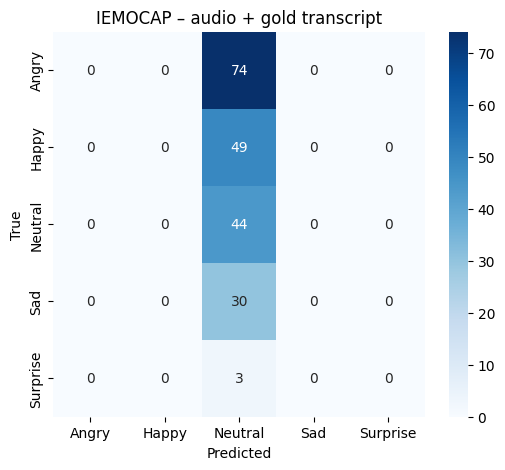

>>> IEMOCAP – AUDIO + WHISPER TRANSCRIPT


Classify (audio+whisper):   0%|          | 0/200 [00:00<?, ?it/s]

Error on /content/drive/MyDrive/adsp/downloads/iemocap/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M023.wav -> OutOfMemoryError CUDA out of memory. Tried to allocate 1.19 GiB. GPU 0 has a total capacity of 14.74 GiB of which 626.12 MiB is free. Process 76234 has 14.13 GiB memory in use. Of the allocated memory 12.83 GiB is allocated by PyTorch, and 1.17 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error on /content/drive/MyDrive/adsp/downloads/iemocap/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M010.wav -> OutOfMemoryError CUDA out of memory. Tried to allocate 1.19 GiB. GPU 0 has a total capacity of 14.74 GiB of which 626.12 MiB is free. Process 76234 has 14.13 GiB memory in use. Of the allocated memory 12.83 GiB is al

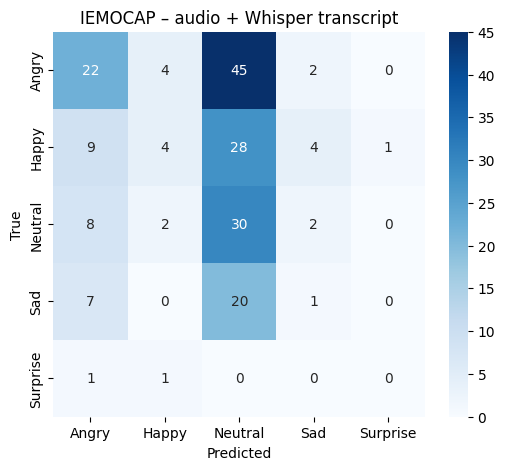

In [14]:
MAX_SAMPLES = 200

# ---------- ESD ----------
print(">>> ESD – AUDIO ONLY")
esd_audio_only = classify_batch(df_esd_w, mode="audio", max_samples=MAX_SAMPLES)
acc_esd_a, cm_esd_a = evaluate_predictions(esd_audio_only, title="ESD – audio only")

print(">>> ESD – AUDIO + GOLD TRANSCRIPT")
esd_audio_gold = classify_batch(df_esd_w, mode="audio+gold", max_samples=MAX_SAMPLES)
acc_esd_ag, cm_esd_ag = evaluate_predictions(esd_audio_gold, title="ESD – audio + gold transcript")

print(">>> ESD – AUDIO + WHISPER TRANSCRIPT")
esd_audio_whisp = classify_batch(df_esd_w, mode="audio+whisper", max_samples=MAX_SAMPLES)
acc_esd_aw, cm_esd_aw = evaluate_predictions(esd_audio_whisp, title="ESD – audio + Whisper transcript")


# ---------- IEMOCAP ----------
print(">>> IEMOCAP – AUDIO ONLY")
iemo_audio_only = classify_batch(df_iemo_w, mode="audio", max_samples=MAX_SAMPLES)
acc_ie_a, cm_ie_a = evaluate_predictions(iemo_audio_only, title="IEMOCAP – audio only")

print(">>> IEMOCAP – AUDIO + GOLD TRANSCRIPT")
iemo_audio_gold = classify_batch(df_iemo_w, mode="audio+gold", max_samples=MAX_SAMPLES)
acc_ie_ag, cm_ie_ag = evaluate_predictions(iemo_audio_gold, title="IEMOCAP – audio + gold transcript")

print(">>> IEMOCAP – AUDIO + WHISPER TRANSCRIPT")
iemo_audio_whisp = classify_batch(df_iemo_w, mode="audio+whisper", max_samples=MAX_SAMPLES)
acc_ie_aw, cm_ie_aw = evaluate_predictions(iemo_audio_whisp, title="IEMOCAP – audio + Whisper transcript")
